In [15]:
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [16]:
discrete = pd.read_csv('/Users/tianchiz/Desktop/Aviana project/USC_Discrete_Target_Dataset_New.csv')

In [18]:
column_type_df = pd.read_csv('/Users/tianchiz/Desktop/Aviana project/nemesis-ml-master-2/data/processed/USC_Discret_column_type.csv')

In [29]:
def XGB_Classifier(dataset, dataset_type, test_size = 0.2):
    import xgboost as xgb
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn import metrics
    
    #Function to get target variable
    def get_target(df,df_type):
        for c in df:
            if (column_type(c,df_type) == 'Flag_Continuous' or column_type(c,df_type) == 'Flag_Categorical'):
                return(c)
            
    # funtion to get column type
    def column_type(column_name,df_type):
        return (df_type.loc[df_type['Variable'] == column_name, 'Type'].iloc[0])
    
    print('The current dataset has',dataset.shape[1],'columns and',dataset.shape[0],'rows\n')
    print('Column names are', dataset.columns, '\n')
    print('The first 10 rows of this dataset:')
    print(dataset.head(10))
    
    # split data into X and Y
    target_name = get_target(dataset, dataset_type)
    X = dataset.drop(columns = target_name)
    Y = dataset[target_name]
    
    # split data into train and test sets
    seed = 0
    test_size = test_size
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)
    
    # fit model no training data
    model = XGBClassifier()
    model.fit(x_train, y_train)
    
    # important features
    xgb.plot_importance(model)
    plt.show()
    
    # make predictions for test data
    y_pred = model.predict(x_test)
    
    # print the confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    print('The confusion matrix is:\n', cnf_matrix, '\n')
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # save the model to disk
    filename = '../../models/XGBClassifier.sav'
    pickle.dump(xgb_classifier, open(filename, 'wb'))

The current dataset has 14 columns and 14112 rows

Column names are Index(['BUS__CODE', 'SCORE', 'A_GrossSales', 'A_ExtaxPurch', 'A_Resales',
       'A_FoodCosts', 'A_LaborCosts', 'A_IOC', 'A_BadDebts', 'A_TOPP',
       'A_SalesFinal', 'OwnCode', 'Status', 'Y_AuditResult'],
      dtype='object') 

The first 10 rows of this dataset:
   BUS__CODE     SCORE  A_GrossSales  A_ExtaxPurch  A_Resales  A_FoodCosts  \
0          1  0.159487      0.050649      0.057615   0.052424     0.054121   
1          5  0.159487      0.350000      0.297216   0.234368     0.292196   
2          5  0.159487      0.269103      0.455882   0.345161     0.292196   
3          5  0.159487      0.269350      0.170758   0.345161     0.292196   
4          6  0.228013      0.421769      0.455882   0.909091     0.292196   
5          5  0.159487      0.050649      0.057615   0.052424     0.054121   
6          5  0.215543      0.050649      0.057615   0.052424     0.054121   
7          1  0.159487      0.050649      

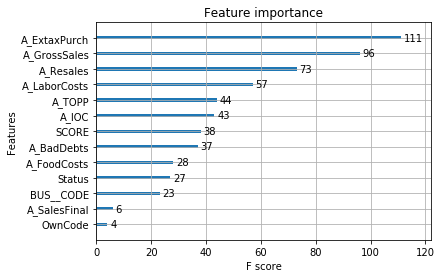

The confusion matrix is:
 [[2244   34]
 [ 407  138]] 

Accuracy: 84.38%


In [30]:
XGB_Classifier(discrete, column_type_df)